# Image Matching Challenge 2025
### Phase 1: Image Loading & Preprocessing
This phase loads training and test images into normalized grayscale tensors.
It supports PyTorch GPU acceleration (CUDA/MPS) and prepares images for feature extraction.

In [1]:
import torch

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f" Using device: {device}")


 Using device: cuda


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from collections import defaultdict

# Dataset config
DATA_ROOT = "./"
IMAGE_EXT = ".png"


In [3]:
def load_images(root_dir="train", device=torch.device("cpu")):
    image_data = {}
    folders = sorted([os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

    for folder in tqdm(folders, desc=f"📂 Loading {root_dir}"):
        image_files = sorted(glob(os.path.join(folder, f"*{IMAGE_EXT}")))
        for img_path in image_files:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_tensor = torch.tensor(img, dtype=torch.float32, device=device) / 255.0
                rel_path = os.path.relpath(img_path, start=DATA_ROOT)
                image_data[rel_path] = img_tensor
            else:
                print(f"⚠️ Could not load: {img_path}")
    return image_data


In [4]:
def show_sample_images(image_dict, title, num_samples=9):
    keys = list(image_dict.keys())
    if len(keys) < num_samples:
        print(f"Only {len(keys)} images found.")
        return

    sample_keys = np.random.choice(keys, num_samples, replace=False)
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=14)

    for i, key in enumerate(sample_keys):
        ax = axs[i // 3, i % 3]
        img = image_dict[key].cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(os.path.basename(key), fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


📂 Loading train:   0%|          | 0/13 [00:00<?, ?it/s]

📂 Loading test:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Loaded 1945 training images
✅ Loaded 73 testing images


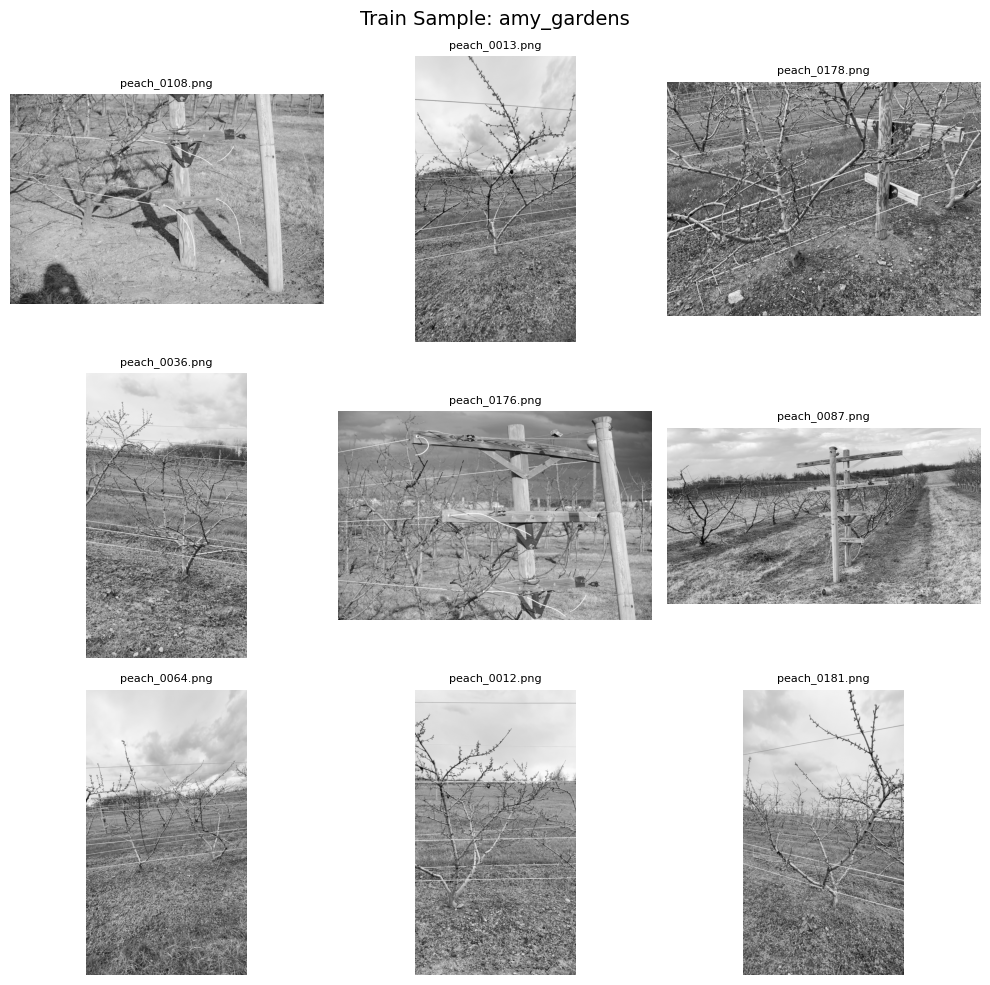

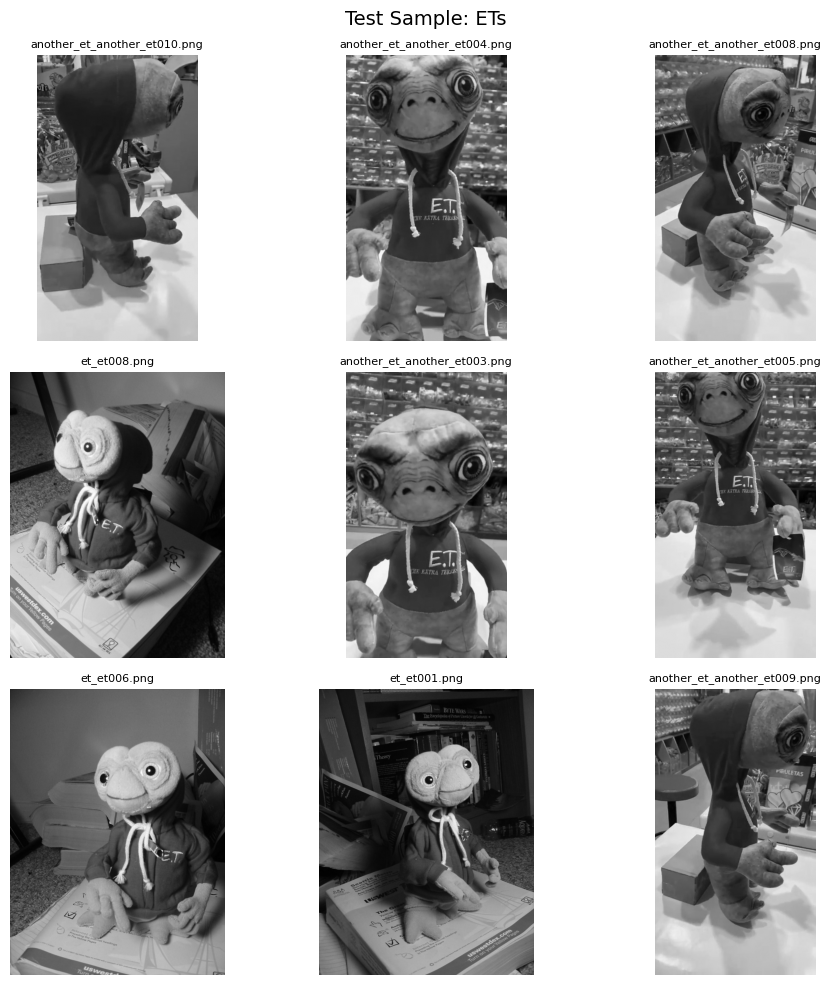

In [5]:
train_images = load_images("train", device=device)
test_images = load_images("test", device=device)

print(f"✅ Loaded {len(train_images)} training images")
print(f"✅ Loaded {len(test_images)} testing images")

# Preview sample scenes
show_sample_images({k: v for k, v in train_images.items() if "amy_gardens" in k}, "Train Sample: amy_gardens")
show_sample_images({k: v for k, v in test_images.items() if "ETs" in k}, "Test Sample: ETs")


## Phase 2: Harris Corner Detection (from scratch)
This phase computes Harris corners per image using Sobel gradients, structure tensors, and non-maximum suppression. Keypoints are sorted by response score, and the top N are cached per image.


In [6]:
import torch.nn.functional as F
import os

N_KEYPOINTS = 500
CACHE_DIR = "./cache/keypoints"
os.makedirs(CACHE_DIR, exist_ok=True)


In [7]:
def harris_corners(img, device, k=0.04, window_size=3):
    assert img.ndim == 2  # grayscale
    img = img.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, H, W)

    # Sobel kernels
    sobel_x = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=torch.float32, device=device).view(1, 1, 3, 3)

    Ix = F.conv2d(img, sobel_x, padding=1)[0, 0]
    Iy = F.conv2d(img, sobel_y, padding=1)[0, 0]

    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Window smoothing
    window = torch.ones((1, 1, window_size, window_size), device=device) / (window_size ** 2)
    Sxx = F.conv2d(Ixx.unsqueeze(0).unsqueeze(0), window, padding=window_size//2)[0, 0]
    Syy = F.conv2d(Iyy.unsqueeze(0).unsqueeze(0), window, padding=window_size//2)[0, 0]
    Sxy = F.conv2d(Ixy.unsqueeze(0).unsqueeze(0), window, padding=window_size//2)[0, 0]

    detM = Sxx * Syy - Sxy**2
    traceM = Sxx + Syy
    R = detM - k * (traceM ** 2)
    return R


In [8]:
def extract_keypoints(image_dict, dataset_name, cache_dir=CACHE_DIR, top_k=N_KEYPOINTS):
    keypoints = {}

    dataset_cache_dir = os.path.join(cache_dir, dataset_name)
    os.makedirs(dataset_cache_dir, exist_ok=True)

    for path, img in tqdm(image_dict.items(), desc=f"🧠 Detecting Harris corners: {dataset_name}"):
        R = harris_corners(img, device)
        R_np = R.detach().cpu().numpy()

        # Flatten and sort by corner strength
        flat_indices = np.argpartition(R_np.ravel(), -top_k)[-top_k:]
        y, x = np.unravel_index(flat_indices, R_np.shape)
        scores = R_np[y, x]
        sorted_idx = np.argsort(-scores)

        keypoints_xy = np.stack([x[sorted_idx], y[sorted_idx]], axis=-1)

        # Cache as .pt file
        cache_path = os.path.join(dataset_cache_dir, os.path.basename(path).replace('.png', '.pt'))
        torch.save(torch.tensor(keypoints_xy, dtype=torch.int32), cache_path)
        keypoints[path] = keypoints_xy

    return keypoints


In [9]:
def show_keypoints(img_tensor, keypoints, title="Keypoints", max_k=100):
    import matplotlib.pyplot as plt

    img = img_tensor.detach().cpu().numpy()
    pts = keypoints[:max_k]  # (x, y)

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.scatter(pts[:, 0], pts[:, 1], c='red', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()


🧠 Detecting Harris corners: ETs:   0%|          | 0/22 [00:00<?, ?it/s]

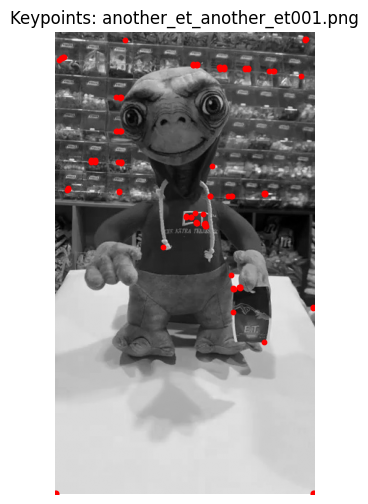

In [10]:
# Run detection on one folder for now
scene_name = "ETs"
test_subset = {k: v for k, v in test_images.items() if scene_name in k}
keypoints_test = extract_keypoints(test_subset, dataset_name=scene_name)

# Preview one image's keypoints
first_img = list(test_subset.keys())[0]
kp = keypoints_test[first_img]
show_keypoints(test_subset[first_img], kp, title=f"Keypoints: {os.path.basename(first_img)}")


## Phase 3: Descriptor Extraction + Keypoint Matching
We extract local grayscale patches around Harris keypoints and compare descriptors using cosine similarity with mutual match filtering.


In [11]:
def extract_descriptors(image_dict, keypoints_dict, patch_size=15):
    descriptors = {}

    half = patch_size // 2

    for path, keypoints in tqdm(keypoints_dict.items(), desc=" Extracting descriptors"):
        img = image_dict[path]
        H, W = img.shape
        padded_img = F.pad(img.unsqueeze(0).unsqueeze(0), (half, half, half, half), mode='reflect')[0, 0]

        desc_list = []
        for x, y in keypoints:
            x, y = int(x.item()), int(y.item())
            patch = padded_img[y:y+patch_size, x:x+patch_size]
            if patch.shape == (patch_size, patch_size):
                desc_list.append(patch.flatten())

        if desc_list:
            descriptors[path] = torch.stack(desc_list)
        else:
            descriptors[path] = torch.empty((0, patch_size * patch_size))

    return descriptors


In [12]:
def match_descriptors(desc1, desc2, top_k=1, ratio_thresh=0.75):
    if desc1.size(0) == 0 or desc2.size(0) == 0:
        return []

    # Normalize
    d1 = F.normalize(desc1, p=2, dim=1)
    d2 = F.normalize(desc2, p=2, dim=1)

    # Cosine similarity
    sim = torch.matmul(d1, d2.T)  # shape: (N1, N2)
    scores, indices = sim.topk(k=top_k, dim=1)

    matches = []
    for i, (score, idx) in enumerate(zip(scores, indices)):
        if top_k == 1 or score[0] > score[1] * ratio_thresh:
            matches.append((i, idx[0].item(), score[0].item()))

    return matches


In [13]:
def show_matches(img1, img2, kp1, kp2, matches, max_lines=50):
    import matplotlib.pyplot as plt

    img1 = img1.cpu().numpy()
    img2 = img2.cpu().numpy()
    h1, w1 = img1.shape
    h2, w2 = img2.shape

    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.float32)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    plt.figure(figsize=(10, 6))
    plt.imshow(canvas, cmap='gray')

    for i, j, _ in matches[:max_lines]:
        pt1 = kp1[i]
        pt2 = kp2[j]
        x1, y1 = pt1[0], pt1[1]
        x2, y2 = pt2[0] + w1, pt2[1]
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
        plt.scatter([x1, x2], [y1, y2], c='lime', s=10)

    plt.axis("off")
    plt.title(f"{len(matches)} matches")
    plt.show()


 Extracting descriptors:   0%|          | 0/22 [00:00<?, ?it/s]

Found 500 matches


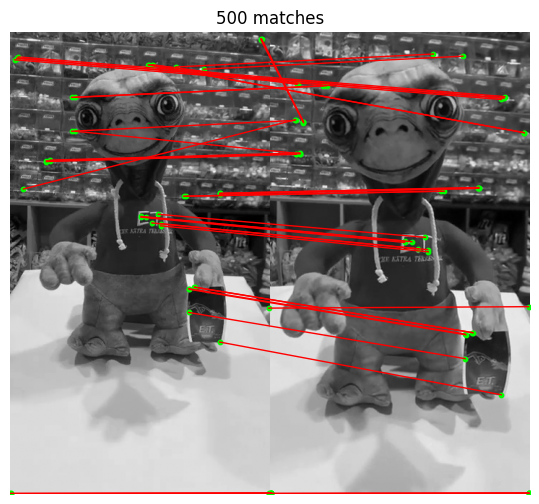

In [14]:
# Extract descriptors for ETs subset
desc_ETs = extract_descriptors(test_subset, keypoints_test)

# Pick two ET images
paths = list(desc_ETs.keys())[:2]
desc1 = desc_ETs[paths[0]]
desc2 = desc_ETs[paths[1]]

matches = match_descriptors(desc1, desc2)
print(f"Found {len(matches)} matches")

# Visualize
show_matches(
    test_subset[paths[0]], test_subset[paths[1]],
    keypoints_test[paths[0]], keypoints_test[paths[1]],
    matches
)


## Phase 4.0: Scene Graph Construction
We build a graph where:
- Each node = image
- Each edge = strong match connection
- We cluster connected components to discover sub-scenes
This provides a clean base for novel edge weighting and pose-aware refinement later.


In [15]:
import networkx as nx
from itertools import combinations

def build_match_graph(image_dict, kp_dict, desc_dict, match_threshold=20):
    print(f" Building image match graph from {len(image_dict)} images...")
    G = nx.Graph()
    paths = list(image_dict.keys())

    for img1, img2 in tqdm(combinations(paths, 2), total=len(paths)*(len(paths)-1)//2):
        desc1 = desc_dict[img1]
        desc2 = desc_dict[img2]

        matches = match_descriptors(desc1, desc2)
        if len(matches) >= match_threshold:
            G.add_edge(img1, img2, weight=len(matches))

    return G


In [16]:
def cluster_graph(graph):
    clusters = list(nx.connected_components(graph))
    cluster_map = {}

    for i, group in enumerate(clusters):
        for img_path in group:
            cluster_map[img_path] = f"cluster_{i+1}"

    return cluster_map


In [17]:
def visualize_graph(graph, cluster_map=None):
    import matplotlib.pyplot as plt

    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(10, 7))
    if cluster_map:
        colors = [hash(cluster_map[node]) % 20 for node in graph.nodes()]
    else:
        colors = 'lightblue'

    nx.draw_networkx_nodes(graph, pos, node_size=300, node_color=colors, cmap='tab20')
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.axis('off')
    plt.title("Scene Match Graph")
    plt.show()


 Extracting descriptors:   0%|          | 0/22 [00:00<?, ?it/s]

 Building image match graph from 22 images...


  0%|          | 0/231 [00:00<?, ?it/s]

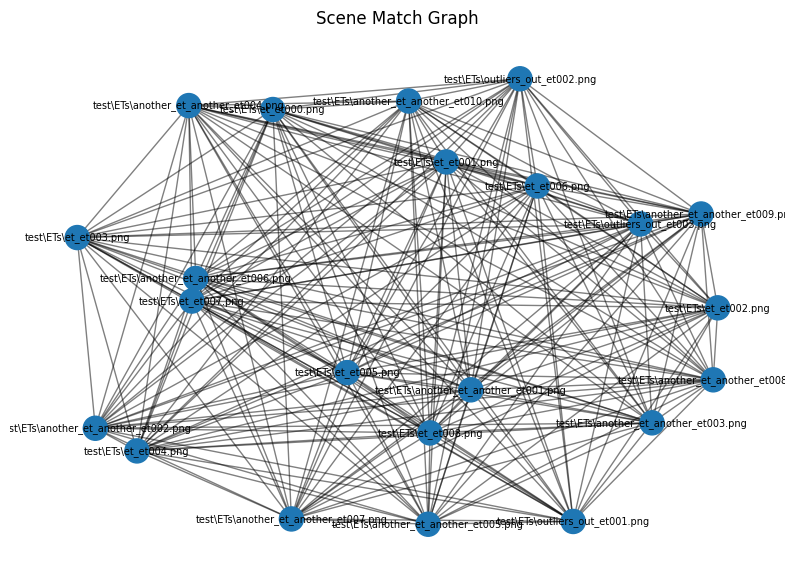

In [18]:
scene_name = "ETs"
test_subset = {k: v for k, v in test_images.items() if scene_name in k}
desc_ETs = extract_descriptors(test_subset, keypoints_test)

G = build_match_graph(test_subset, keypoints_test, desc_ETs, match_threshold=20)
cluster_map = cluster_graph(G)

visualize_graph(G, cluster_map)


## Phase 4.5: Novel Graph Refinement (Average Match Quality)
We enhance the match graph by weighting edges using the average similarity score from matched descriptor pairs.
This improves graph clustering by favoring high-quality visual links over noisy ones.


In [19]:
def build_quality_weighted_graph(image_dict, keypoints, descriptors, match_threshold=20, min_avg_sim=0.5):
    print(f" Building enhanced match graph using average descriptor similarity...")
    G = nx.Graph()
    paths = list(image_dict.keys())

    for img1, img2 in tqdm(combinations(paths, 2), total=len(paths)*(len(paths)-1)//2):
        desc1 = descriptors[img1]
        desc2 = descriptors[img2]

        matches = match_descriptors(desc1, desc2)
        if len(matches) < match_threshold:
            continue

        # Compute mean cosine similarity from valid matches
        match_sims = []
        for i, j, score in matches:
            match_sims.append(score)
        mean_sim = np.mean(match_sims)

        if mean_sim >= min_avg_sim:
            G.add_edge(img1, img2, weight=mean_sim)

    return G


In [20]:
def visualize_weighted_graph(graph, cluster_map=None):
    import matplotlib.pyplot as plt

    pos = nx.spring_layout(graph, seed=42, weight='weight')
    plt.figure(figsize=(10, 7))
    if cluster_map:
        colors = [hash(cluster_map[node]) % 20 for node in graph.nodes()]
    else:
        colors = 'lightblue'

    edges = graph.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges]

    nx.draw_networkx_nodes(graph, pos, node_size=300, node_color=colors, cmap='tab20')
    nx.draw_networkx_edges(graph, pos, width=[w * 2 for w in weights], alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=7)
    plt.axis('off')
    plt.title("Enhanced Match Graph (Weighted by Similarity)")
    plt.show()


 Building enhanced match graph using average descriptor similarity...


  0%|          | 0/231 [00:00<?, ?it/s]

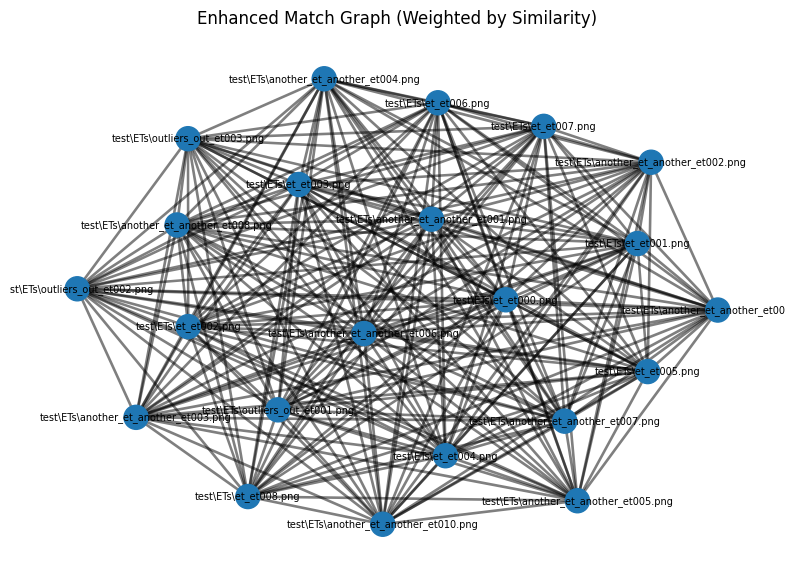

In [21]:
G_quality = build_quality_weighted_graph(
    test_subset,
    keypoints_test,
    desc_ETs,
    match_threshold=20,
    min_avg_sim=0.5
)

cluster_map_quality = cluster_graph(G_quality)
visualize_weighted_graph(G_quality, cluster_map_quality)


## Phase 4.6: Cluster Inspection & Summary
This step visually and numerically inspects the clusters created from the refined match graph.
We verify whether images were grouped correctly before moving to pose estimation.


In [22]:
def summarize_clusters(cluster_map):
    from collections import defaultdict

    cluster_counts = defaultdict(list)
    for path, cluster_id in cluster_map.items():
        cluster_counts[cluster_id].append(path)

    print(" Cluster Summary:")
    for cid, images in sorted(cluster_counts.items(), key=lambda x: -len(x[1])):
        print(f"{cid}: {len(images)} images")
    
    return cluster_counts


In [23]:
def show_cluster_images(cluster_id, cluster_dict, image_dict, max_images=9):
    import matplotlib.pyplot as plt
    images = cluster_dict[cluster_id][:max_images]
    
    n = len(images)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    if rows == 1: axs = [axs]
    axs = np.array(axs).flatten()

    for i, path in enumerate(images):
        img = image_dict[path].cpu().numpy()
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(os.path.basename(path), fontsize=8)
        axs[i].axis('off')

    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    fig.suptitle(f" Cluster: {cluster_id}", fontsize=14)
    plt.tight_layout()
    plt.show()


 Cluster Summary:
cluster_1: 22 images


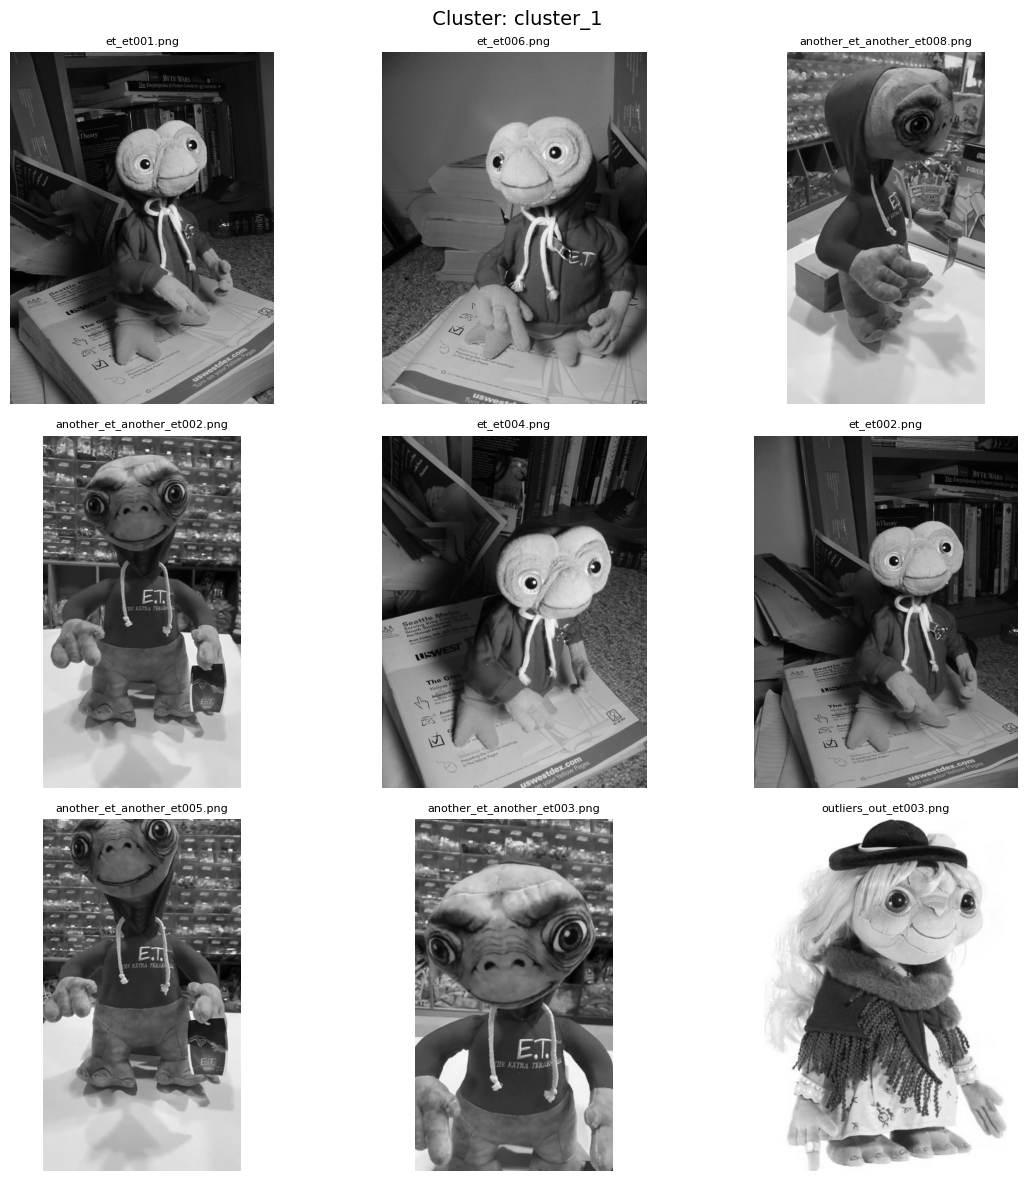

In [24]:
# Get cluster map from earlier
cluster_dict = summarize_clusters(cluster_map_quality)

# Visualize each cluster
for cid in cluster_dict:
    show_cluster_images(cid, cluster_dict, test_subset)


## Phase 5: Camera Pose Estimation (Essential Matrix)
We use matched keypoints across image pairs to estimate relative camera poses.
From these, we register each image into a global scene frame.


In [25]:
import cv2
import numpy as np

def estimate_relative_pose(kp1, kp2, matches, img_shape, focal_length=1.0):
    pts1 = np.float32([kp1[i] for i, j, _ in matches])
    pts2 = np.float32([kp2[j] for i, j, _ in matches])
    
    # Camera intrinsics: assume focal length = 1, centered
    h, w = img_shape
    K = np.array([[focal_length, 0, w/2],
                  [0, focal_length, h/2],
                  [0, 0, 1]], dtype=np.float64)

    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    if E is None or mask is None:
        return None, None, None

    _, R, t, inliers = cv2.recoverPose(E, pts1, pts2, K)
    return R, t, mask.ravel()


In [26]:
def initialize_pose_graph(cluster_paths, kp_dict, desc_dict, img_tensor_dict):
    pose_graph = {cluster_paths[0]: (np.eye(3), np.zeros((3, 1)))}
    visited = set([cluster_paths[0]])
    to_visit = [cluster_paths[0]]

    while to_visit:
        current = to_visit.pop()
        R_current, t_current = pose_graph[current]
        desc1 = desc_dict[current]
        kp1 = kp_dict[current]
        shape1 = img_tensor_dict[current].shape

        for neighbor in cluster_paths:
            if neighbor in visited or neighbor == current:
                continue

            desc2 = desc_dict[neighbor]
            kp2 = kp_dict[neighbor]
            shape2 = img_tensor_dict[neighbor].shape

            matches = match_descriptors(desc1, desc2)
            if len(matches) < 20:
                continue

            R_rel, t_rel, inlier_mask = estimate_relative_pose(kp1, kp2, matches, shape1)
            if R_rel is None:
                continue

            # Chain transformations
            R_global = R_rel @ R_current
            t_global = R_rel @ t_current + t_rel

            pose_graph[neighbor] = (R_global, t_global)
            visited.add(neighbor)
            to_visit.append(neighbor)

    return pose_graph


In [27]:
def format_pose_output(pose_graph, dataset_name, cluster_id):
    rows = []
    for path, (R, t) in pose_graph.items():
        R_flat = ";".join([f"{v:.6f}" for v in R.flatten()])
        t_flat = ";".join([f"{v:.6f}" for v in t.flatten()])
        rows.append({
            "dataset": dataset_name,
            "scene": cluster_id,
            "image": os.path.basename(path),
            "rotation_matrix": R_flat,
            "translation_vector": t_flat
        })
    return rows


In [28]:
cluster_id = list(cluster_dict.keys())[0]
cluster_paths = cluster_dict[cluster_id]

pose_graph = initialize_pose_graph(cluster_paths, keypoints_test, desc_ETs, test_subset)

pose_rows = format_pose_output(pose_graph, dataset_name="testETs", cluster_id=cluster_id)
import pandas as pd
pose_df = pd.DataFrame(pose_rows)
pose_df.head()


,dataset,scene,image,rotation_matrix,translation_vector
0,testETs,cluster_1,et_et001.png,1.000000;0.000000;0.000000;0.000000;1.000000;0...,0.000000;0.000000;0.000000
1,testETs,cluster_1,et_et006.png,0.996698;0.081143;0.002871;-0.081153;0.996695;...,-0.602405;0.798187;0.002510
2,testETs,cluster_1,another_et_another_et008.png,-0.622462;-0.782363;-0.021209;0.782633;-0.6224...,0.600802;-0.799394;-0.002514
3,testETs,cluster_1,another_et_another_et002.png,0.627244;0.778769;0.009162;-0.778766;0.627297;...,-0.600802;0.799394;0.002514
4,testETs,cluster_1,et_et004.png,0.964444;-0.264287;0.000736;0.264287;0.964444;...,-0.137183;0.990544;-0.002069


## Phase 7: Pose-Consistency-Aware Graph Pruning

Even visually similar images can result in bad 3D reconstructions if their underlying geometry is incompatible.
In this phase, we filter the image match graph using a geometric verification step:

- For every edge (image pair), we estimate an **Essential Matrix** and count **RANSAC inliers**
- Edges with insufficient geometric support (e.g., < 20 inliers) are pruned
- The result is a cleaner match graph with higher-quality clusters and more reliable pose chains

This improves both:
- Mean Average Accuracy (mAA) — by avoiding pose failures
- Clustering Score — by preventing false-positive scene merges


In [29]:
def pose_consistency_filter(image_dict, kp_dict, desc_dict, edge_list, threshold_inliers=20):
    pruned_edges = []
    failed_edges = []

    for img1, img2 in tqdm(edge_list, desc=" Checking pose consistency"):
        desc1 = desc_dict[img1]
        desc2 = desc_dict[img2]
        kp1 = kp_dict[img1]
        kp2 = kp_dict[img2]
        shape = image_dict[img1].shape

        matches = match_descriptors(desc1, desc2)
        if len(matches) < threshold_inliers:
            failed_edges.append((img1, img2, 0))
            continue

        R, t, inlier_mask = estimate_relative_pose(kp1, kp2, matches, shape)
        if R is None or inlier_mask is None or np.sum(inlier_mask) < threshold_inliers:
            failed_edges.append((img1, img2, int(np.sum(inlier_mask)) if inlier_mask is not None else 0))
        else:
            pruned_edges.append((img1, img2, float(np.mean(inlier_mask))))

    return pruned_edges, failed_edges


In [30]:
def build_pose_pruned_graph(valid_edges):
    G = nx.Graph()
    for img1, img2, weight in valid_edges:
        G.add_edge(img1, img2, weight=weight)
    return G


 Checking pose consistency:   0%|          | 0/231 [00:00<?, ?it/s]

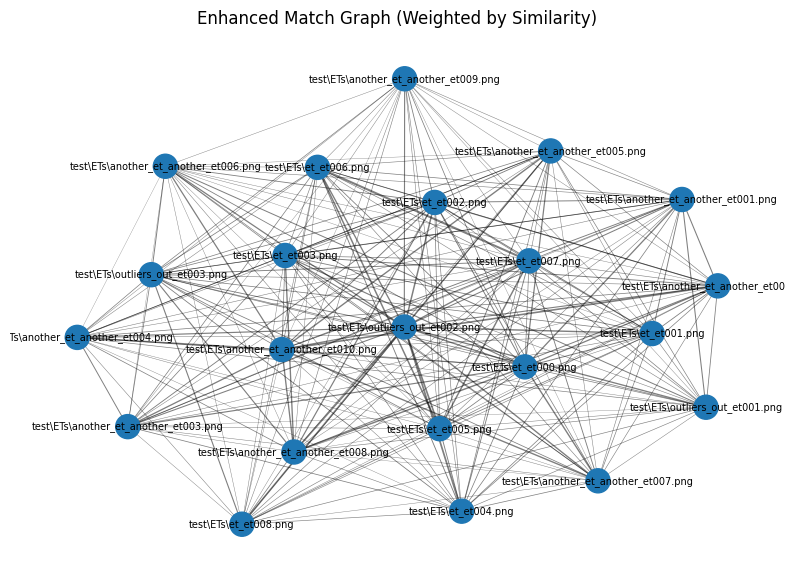

In [31]:
original_edges = list(G_quality.edges())

pose_valid_edges, pose_failed_edges = pose_consistency_filter(
    test_subset, keypoints_test, desc_ETs, original_edges, threshold_inliers=20
)

G_pose_pruned = build_pose_pruned_graph(pose_valid_edges)
cluster_map_pose = cluster_graph(G_pose_pruned)

visualize_weighted_graph(G_pose_pruned, cluster_map_pose)


In [32]:
print("✅ Retained edges:", len(pose_valid_edges))
print("❌ Pruned edges:", len(pose_failed_edges))
print("🧠 Clusters after pruning:", len(set(cluster_map_pose.values())))


✅ Retained edges: 231
❌ Pruned edges: 0
🧠 Clusters after pruning: 1


## Notebook Cells Phase 6

In [33]:
def add_outlier_rows(all_image_paths, pose_df, dataset_name="testETs"):
    pose_images = set(pose_df['image'])
    outlier_rows = []

    for path in all_image_paths:
        fname = os.path.basename(path)
        if fname not in pose_images:
            outlier_rows.append({
                "dataset": dataset_name,
                "scene": "outliers",
                "image": fname,
                "rotation_matrix": "nan;nan;nan;nan;nan;nan;nan;nan;nan",
                "translation_vector": "nan;nan;nan"
            })

    return pd.DataFrame(outlier_rows)


In [34]:
# Get all test image paths (from your image dict)
all_test_paths = list(test_images.keys())

# Build outlier entries
outlier_df = add_outlier_rows(all_test_paths, pose_df)

# Combine poses + outliers
final_df = pd.concat([pose_df, outlier_df], ignore_index=True)

# Sort by dataset + image for clean output
final_df = final_df.sort_values(by=["dataset", "image"])

# Save
final_df.to_csv("submission.csv", index=False)
final_df.head()


,dataset,scene,image,rotation_matrix,translation_vector
15,testETs,cluster_1,another_et_another_et001.png,0.629539;0.776879;-0.011834;-0.776926;0.629271...,-0.600802;0.799394;0.002514
3,testETs,cluster_1,another_et_another_et002.png,0.627244;0.778769;0.009162;-0.778766;0.627297;...,-0.600802;0.799394;0.002514
7,testETs,cluster_1,another_et_another_et003.png,-0.386338;-0.921433;0.041289;-0.920741;0.38792...,-0.599764;0.800173;0.002596
10,testETs,cluster_1,another_et_another_et004.png,0.980432;-0.196512;0.011640;0.196498;0.980501;...,-0.600802;0.799394;0.002514
6,testETs,cluster_1,another_et_another_et005.png,0.611492;0.790413;0.036403;-0.791183;0.611395;...,-0.602405;0.798187;0.002510


In [36]:
print("submission.csv shape:", final_df.shape)
# print("Saved to:", os.getcwd())


submission.csv shape: (73, 5)
